# ARIMA (AutoRegressive Integrated Moving Average) Model

**=====Imports=====**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ Libraries loaded")

✅ Libraries loaded


**=====Helper Functions=====**

In [2]:
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    num = np.abs(y_pred - y_true)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-6, denom)
    return np.mean(num / denom) * 100

def test_stationarity(series, name="Series"):
    """
    Test stationarity using ADF and KPSS tests
    
    ADF Test: H0 = Non-stationary (unit root exists)
        - p < 0.05 → Reject H0 → Stationary ✅
        - p > 0.05 → Fail to reject H0 → Non-stationary ❌
    
    KPSS Test: H0 = Stationary
        - p > 0.05 → Fail to reject H0 → Stationary ✅
        - p < 0.05 → Reject H0 → Non-stationary ❌
    """
    print(f"\n{'='*60}")
    print(f"    STATIONARITY TESTS: {name}")
    print(f"{'='*60}")
    
    # ADF Test
    adf_result = adfuller(series.dropna(), autolag='AIC')
    print(f"\n📊 ADF Test (H0: Non-stationary):")
    print(f"   Test Statistic: {adf_result[0]:.4f}")
    print(f"   p-value: {adf_result[1]:.4f}")
    print(f"   Critical Values:")
    for key, value in adf_result[4].items():
        print(f"      {key}: {value:.4f}")
    
    adf_stationary = adf_result[1] < 0.05
    print(f"   Result: {'✅ STATIONARY' if adf_stationary else '❌ NON-STATIONARY'}")
    
    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
    print(f"\n📊 KPSS Test (H0: Stationary):")
    print(f"   Test Statistic: {kpss_result[0]:.4f}")
    print(f"   p-value: {kpss_result[1]:.4f}")
    print(f"   Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"      {key}: {value:.4f}")
    
    kpss_stationary = kpss_result[1] > 0.05
    print(f"   Result: {'✅ STATIONARY' if kpss_stationary else '❌ NON-STATIONARY'}")
    
    # Combined conclusion
    print(f"\n🎯 CONCLUSION:")
    if adf_stationary and kpss_stationary:
        print(f"   Both tests agree: Series IS STATIONARY ✅")
        return True
    elif not adf_stationary and not kpss_stationary:
        print(f"   Both tests agree: Series IS NON-STATIONARY ❌")
        print(f"   → Differencing required for ARIMA")
        return False
    else:
        print(f"   Tests disagree: Results inconclusive ⚠️")
        return False

print("✅ Helper functions defined")

✅ Helper functions defined


**=====Configuration=====**

In [3]:
# ===== CONFIGURATION =====

# Auto-detect project paths
current_dir = Path.cwd()
if 'Model_Training' in str(current_dir):
    project_root = current_dir.parent.parent
else:
    project_root = current_dir

# Define paths
MERGE_DIR = project_root / "Merge_Dataset"
MERGE_CSV = MERGE_DIR / "Merged_Imputed_Dataset.csv"
MODELS_DIR = project_root / "Models Results"

# Create directories if needed
MODELS_DIR.mkdir(exist_ok=True)

# Training configuration
CUT_OFF_YEAR = 2018
RANDOM_STATE = 42

print(f"📁 Project root: {project_root}")
print(f"📁 Using dataset: {MERGE_CSV.name}")
print("✅ Configuration loaded")

📁 Project root: c:\FYP Finding\Inflation_Forecasting
📁 Using dataset: Merged_Imputed_Dataset.csv
✅ Configuration loaded


**=====Load Data=====**

In [4]:
# ============================================================
#              LOAD DATA - GLOBAL AGGREGATION
# ============================================================

df = pd.read_csv(MERGE_CSV)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Period: {df['Year'].min()} - {df['Year'].max()}")
print(f"Countries: {df['Country'].nunique()}")

# Create global average inflation time series
global_inflation = df.groupby('Year')['Inflation'].mean().reset_index()

# Create target: next year's inflation (shift)
global_inflation['Inflation_next'] = global_inflation['Inflation'].shift(-1)

# Remove last row (no target for 2024)
global_inflation = global_inflation.dropna(subset=['Inflation_next'])

print(f"\n✅ Global inflation time series created: {len(global_inflation)} years")
print(f"   Range: {global_inflation['Year'].min()} - {global_inflation['Year'].max()}")
print(f"   Training: {(global_inflation['Year'] <= CUT_OFF_YEAR).sum()} years")
print(f"   Testing:  {(global_inflation['Year'] > CUT_OFF_YEAR).sum()} years")

# Preview
print(f"\n=== Time Series Preview ===")
display(global_inflation.head(10))
print(f"\n=== Summary Statistics ===")
print(global_inflation.describe())

Dataset loaded: 11935 rows × 17 columns
Period: 1990 - 2024
Countries: 341

✅ Global inflation time series created: 34 years
   Range: 1990 - 2023
   Training: 29 years
   Testing:  5 years

=== Time Series Preview ===


,Year,Inflation,Inflation_next
0,1990,48.839718,24.890886
1,1991,24.890886,40.392075
2,1992,40.392075,62.405454
3,1993,62.405454,128.525209
4,1994,128.525209,28.700552
5,1995,28.700552,23.661155
6,1996,23.661155,12.423847
7,1997,12.423847,8.054014
8,1998,8.054014,9.266866
9,1999,9.266866,9.454718



=== Summary Statistics ===
              Year   Inflation  Inflation_next
count    34.000000   34.000000       34.000000
mean   2006.500000   15.695825       14.454033
std       9.958246   24.200544       23.522030
min    1990.000000    3.759270        3.759270
25%    1998.250000    5.335428        5.335428
50%    2006.500000    6.363051        6.363051
75%    2014.750000    9.587522        9.407755
max    2023.000000  128.525209      128.525209


**=====Train/Test Split=====**

In [5]:
# ============================================================
#                    TRAIN/TEST SPLIT
# ============================================================

train_ts = global_inflation[global_inflation['Year'] <= CUT_OFF_YEAR].copy()
test_ts = global_inflation[global_inflation['Year'] > CUT_OFF_YEAR].copy()

print(f"Train shape: ({len(train_ts)}, {train_ts.shape[1]})")
print(f"Test shape:  ({len(test_ts)}, {test_ts.shape[1]})")
print(f"Train years: {train_ts['Year'].min()} to {train_ts['Year'].max()}")
print(f"Test years:  {test_ts['Year'].min()} to {test_ts['Year'].max()}")

# Prepare series
y_train = train_ts['Inflation'].values  # Changed from Inflation_current
y_test = test_ts['Inflation_next'].values

print(f"\n=== Final Shapes ===")
print(f"y_train: ({len(y_train)},) - Training inflation values")
print(f"y_test:  ({len(y_test)},) - Target inflation values")

print("\n✅ Time series split completed!")
print("\n⚠️  NOTE: ARIMA is UNIVARIATE")
print("   → Uses ONLY past inflation values. Cannot use GDP, Interest Rates, etc.")

Train shape: (29, 3)
Test shape:  (5, 3)
Train years: 1990 to 2018
Test years:  2019 to 2023

=== Final Shapes ===
y_train: (29,) - Training inflation values
y_test:  (5,) - Target inflation values

✅ Time series split completed!

⚠️  NOTE: ARIMA is UNIVARIATE
   → Uses ONLY past inflation values. Cannot use GDP, Interest Rates, etc.


**=====Stationarity Analysis=====**

In [16]:
# === Stationarity Test Function (ADF + KPSS) ===
def test_stationarity(series, series_name="Time Series"):
    print("\n" + "="*60)
    print(f"    STATIONARITY TESTS: {series_name}")
    print("="*60)

    # ----- ADF -----
    print("\n📊 ADF Test (H0: Series is NON-stationary):")
    adf_result = adfuller(series.dropna(), autolag='AIC')
    print(f"   Test Statistic: {adf_result[0]:.4f}")
    print(f"   p-value: {adf_result[1]:.4f}")
    print("   Critical Values:")
    for key, value in adf_result[4].items():
        print(f"      {key}%: {value:.4f}")
    adf_stationary = adf_result[1] < 0.05
    print(f"   Result: {'✅ STATIONARY' if adf_stationary else '❌ NON-STATIONARY'}")

    # ----- KPSS (warnings suppressed) -----
    print("\n📊 KPSS Test (H0: Series IS stationary):")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        kpss_result = kpss(series.dropna(), regression='c', nlags='auto')

    print(f"   Test Statistic: {kpss_result[0]:.4f}")
    print(f"   p-value: {kpss_result[1]:.4f}")
    print("   Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"      {key}%: {value:.4f}")
    kpss_stationary = kpss_result[1] >= 0.05
    print(f"   Result: {'✅ STATIONARY' if kpss_stationary else '❌ NON-STATIONARY'}")

    # ----- Final Conclusion -----
    print("\n🎯 CONCLUSION:")
    if adf_stationary and kpss_stationary:
        print("   Both tests agree: Series IS STATIONARY ✅")
        return True
    else:
        print("   Both tests agree: Series IS NON-STATIONARY ❌")
        print("   → Differencing required for ARIMA")
        return False


# === Run Stationarity Tests ===
is_stationary = test_stationarity(train_ts['Inflation'], "Training Inflation")

if not is_stationary:
    print("\n" + "="*60)
    print("    APPLYING FIRST-ORDER DIFFERENCING")
    print("="*60)

    train_diff = train_ts['Inflation'].diff().dropna()
    is_diff_stationary = test_stationarity(train_diff, "Differenced Inflation")

    if is_diff_stationary:
        print("\n✅ Series is stationary after differencing")
        print("   → Using d=1 in ARIMA(p,d,q)")
        d_order = 1
    else:
        print("\n⚠️ Still non-stationary after differencing")
        print("   → May require d=2 or additional transformation")
        d_order = 1
else:
    print("\n✅ Series is already stationary")
    print("   → Using d=0 in ARIMA(p,d,q)")
    d_order = 0


    STATIONARITY TESTS: Training Inflation

📊 ADF Test (H0: Series is NON-stationary):
   Test Statistic: -2.8233
   p-value: 0.0550
   Critical Values:
      1%%: -3.6889
      5%%: -2.9720
      10%%: -2.6253
   Result: ❌ NON-STATIONARY

📊 KPSS Test (H0: Series IS stationary):
   Test Statistic: 0.4901
   p-value: 0.0439
   Critical Values:
      10%%: 0.3470
      5%%: 0.4630
      2.5%%: 0.5740
      1%%: 0.7390
   Result: ❌ NON-STATIONARY

🎯 CONCLUSION:
   Both tests agree: Series IS NON-STATIONARY ❌
   → Differencing required for ARIMA

    APPLYING FIRST-ORDER DIFFERENCING

    STATIONARITY TESTS: Differenced Inflation

📊 ADF Test (H0: Series is NON-stationary):
   Test Statistic: -4.5236
   p-value: 0.0002
   Critical Values:
      1%%: -3.7112
      5%%: -2.9812
      10%%: -2.6301
   Result: ✅ STATIONARY

📊 KPSS Test (H0: Series IS stationary):
   Test Statistic: 0.1500
   p-value: 0.1000
   Critical Values:
      10%%: 0.3470
      5%%: 0.4630
      2.5%%: 0.5740
      1%%:

**=====ACF/PACF Analysis=====**


ACF highlights correlations across lags and helps identify MA(q).
PACF isolates direct lag effects and helps identify AR(p).
Significant spikes outside the confidence band indicate potential AR or MA terms.



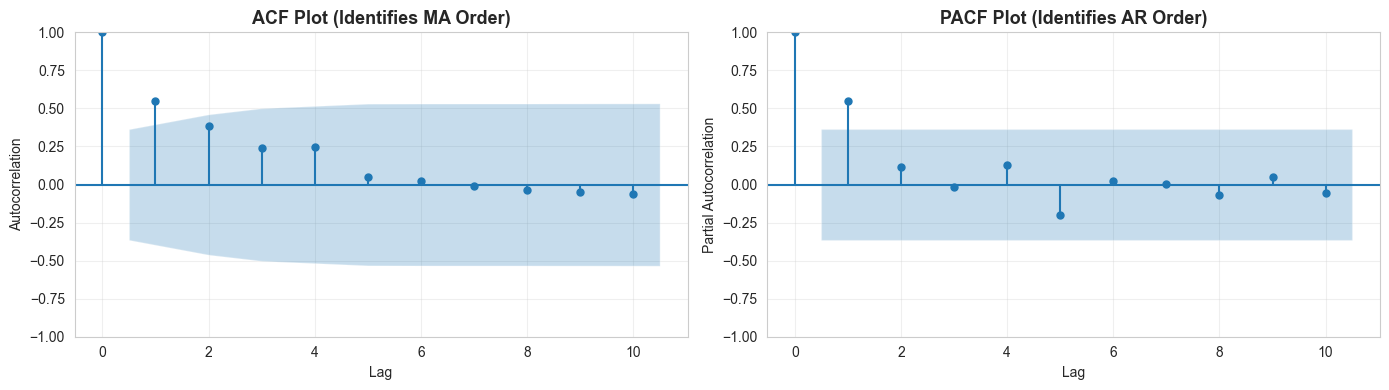


Interpretation Guide:
 - ACF significant at lag k → potential MA(k)
 - PACF significant at lag k → potential AR(k)
 - Gradual decay in both → ARMA/ARIMA model likely appropriate

Proceeding with automated search to determine optimal (p, d, q).


In [17]:
# ============================================================
#          ACF / PACF ANALYSIS – MODEL IDENTIFICATION
# ============================================================

print("""
ACF highlights correlations across lags and helps identify MA(q).
PACF isolates direct lag effects and helps identify AR(p).
Significant spikes outside the confidence band indicate potential AR or MA terms.
""")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ACF
plot_acf(train_ts['Inflation'].dropna(), lags=10, ax=axes[0])
axes[0].set_title('ACF Plot (Identifies MA Order)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(alpha=0.3)

# PACF
plot_pacf(train_ts['Inflation'].dropna(), lags=10, ax=axes[1], method='ywm')
axes[1].set_title('PACF Plot (Identifies AR Order)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation Guide:")
print(" - ACF significant at lag k → potential MA(k)")
print(" - PACF significant at lag k → potential AR(k)")
print(" - Gradual decay in both → ARMA/ARIMA model likely appropriate")
print("\nProceeding with automated search to determine optimal (p, d, q).")

**=====Model Selection (Grid Search)=====**

In [21]:
# ============================================================
#            ARIMA MODEL SELECTION - GRID SEARCH
# ============================================================

print("="*70)
print("          AUTOMATED ARIMA MODEL SELECTION")
print("="*70)
print("\nTesting multiple ARIMA(p, d, q) configurations using AIC.")
print("Lower AIC indicates a better balance between model fit and complexity.\n")

# Define parameter ranges
p_range = [0, 1, 2]  # AR order
d_range = [0, 1]     # Differencing order
q_range = [0, 1, 2]  # MA order

best_aic = np.inf
best_order = None
best_model = None
results_list = []

total_combinations = len(p_range) * len(d_range) * len(q_range) - 1  # Exclude (0,0,0)
print(f"\nTotal combinations to test: {total_combinations}")
print(f"{'='*70}\n")

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # Skip (0,0,0) - not a valid ARIMA
                if p == 0 and d == 0 and q == 0:
                    continue
                
                # Fit ARIMA model
                model = SARIMAX(
                    train_ts['Inflation'],
                    order=(p, d, q),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                fitted = model.fit(disp=False, maxiter=200)
                
                # Store results
                results_list.append({
                    'Order': f"({p},{d},{q})",
                    'p': p,
                    'd': d,
                    'q': q,
                    'AIC': fitted.aic,
                    'BIC': fitted.bic,
                    'Log-Likelihood': fitted.llf
                })
                
                # Track best model
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p, d, q)
                    best_model = fitted
                
                # Print result
                status = "✅ BEST" if (p,d,q) == best_order else "  "
                print(f"{status} ARIMA({p},{d},{q}): AIC={fitted.aic:.2f}, BIC={fitted.bic:.2f}, LogLik={fitted.llf:.2f}")
                
            except Exception as e:
                print(f"   ARIMA({p},{d},{q}): ❌ Failed - {str(e)[:50]}")
                continue

print("\n" + "="*70)
print("          OPTIMAL MODEL SELECTED!")
print("="*70)
print(f"\n🏆 Best ARIMA Order: {best_order}")
print(f"📊 Best AIC: {best_aic:.4f}")
print(f"\n📖 Model Interpretation:")
print(f"   AR({best_order[0]}): Uses last {best_order[0]} inflation value(s)")
print(f"   I({best_order[1]}):  {'First-order differencing applied' if best_order[1]==1 else 'No differencing (series is stationary)'}")
print(f"   MA({best_order[2]}): Uses last {best_order[2]} forecast error(s)")

print(f"\n🔬 What This Means:")
if best_order[0] > 0:
    print(f"   - Past inflation values help predict future inflation")
if best_order[1] > 0:
    print(f"   - Inflation has a trend that needs removing")
if best_order[2] > 0:
    print(f"   - Past forecast errors improve predictions")

# Display all results sorted by AIC
if results_list:
    results_df = pd.DataFrame(results_list).sort_values('AIC').reset_index(drop=True)
    results_df.index = results_df.index + 1
    print(f"\n{'='*70}")
    print("       ALL MODELS RANKED BY AIC (Top 10)")
    print(f"{'='*70}")
    display(results_df.head(10))

print("\n✅ Model training completed!")

          AUTOMATED ARIMA MODEL SELECTION

Testing multiple ARIMA(p, d, q) configurations using AIC.
Lower AIC indicates a better balance between model fit and complexity.


Total combinations to test: 17

✅ BEST ARIMA(0,0,1): AIC=254.72, BIC=257.31, LogLik=-125.36
✅ BEST ARIMA(0,0,2): AIC=242.27, BIC=246.05, LogLik=-118.14
   ARIMA(0,1,0): AIC=249.76, BIC=251.06, LogLik=-123.88
✅ BEST ARIMA(0,1,1): AIC=239.88, BIC=242.39, LogLik=-117.94
✅ BEST ARIMA(0,1,2): AIC=231.17, BIC=234.83, LogLik=-112.58


C:\Users\SURFACBOOK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   ARIMA(1,0,0): AIC=255.02, BIC=257.68, LogLik=-125.51
   ARIMA(1,0,1): AIC=243.79, BIC=247.68, LogLik=-118.89
   ARIMA(1,0,2): AIC=234.38, BIC=239.41, LogLik=-113.19
   ARIMA(1,1,0): AIC=249.31, BIC=251.91, LogLik=-122.66
   ARIMA(1,1,1): AIC=240.63, BIC=244.41, LogLik=-117.32
✅ BEST ARIMA(1,1,2): AIC=227.49, BIC=232.36, LogLik=-109.74
   ARIMA(2,0,0): AIC=247.98, BIC=251.87, LogLik=-120.99
   ARIMA(2,0,1): AIC=243.50, BIC=248.68, LogLik=-117.75
   ARIMA(2,0,2): AIC=228.10, BIC=234.40, LogLik=-109.05
   ARIMA(2,1,0): AIC=242.44, BIC=246.22, LogLik=-118.22
   ARIMA(2,1,1): AIC=241.90, BIC=246.93, LogLik=-116.95
✅ BEST ARIMA(2,1,2): AIC=224.01, BIC=230.11, LogLik=-107.01

          OPTIMAL MODEL SELECTED!

🏆 Best ARIMA Order: (2, 1, 2)
📊 Best AIC: 224.0110

📖 Model Interpretation:
   AR(2): Uses last 2 inflation value(s)
   I(1):  First-order differencing applied
   MA(2): Uses last 2 forecast error(s)

🔬 What This Means:
   - Past inflation values help predict future inflation
   - In

,Order,p,d,q,AIC,BIC,Log-Likelihood
1,"(2,1,2)",2,1,2,224.011042,230.105421,-107.005521
2,"(1,1,2)",1,1,2,227.488751,232.364254,-109.744376
3,"(2,0,2)",2,0,2,228.104852,234.395334,-109.052426
4,"(0,1,2)",0,1,2,231.168714,234.825342,-112.584357
5,"(1,0,2)",1,0,2,234.381640,239.414026,-113.190820
6,"(0,1,1)",0,1,1,239.876717,242.392910,-117.938359
7,"(1,1,1)",1,1,1,240.634182,244.408471,-117.317091
8,"(2,1,1)",2,1,1,241.895062,246.927448,-116.947531
9,"(0,0,2)",0,0,2,242.273963,246.048252,-118.136981
10,"(2,1,0)",2,1,0,242.444744,246.219034,-118.222372



✅ Model training completed!


**=====Model Summary & Diagnostics=====**

In [9]:
# ============================================================
#              MODEL SUMMARY & COEFFICIENTS
# ============================================================

print("="*70)
print("          ARIMA MODEL SUMMARY")
print("="*70)

# Full model summary
print(best_model.summary())

print("\n" + "="*70)
print("          COEFFICIENT INTERPRETATION")
print("="*70)

# Extract coefficients
params = best_model.params
print("\nEstimated Parameters:")
for param_name, param_value in params.items():
    print(f"   {param_name:20s}: {param_value:8.4f}")

# Check significance
pvalues = best_model.pvalues
print("\nParameter Significance (p-values):")
for param_name, pval in pvalues.items():
    sig = "✅ Significant" if pval < 0.05 else "⚠️ Not significant"
    print(f"   {param_name:20s}: {pval:8.4f}  {sig}")

print("\n📊 Goodness of Fit:")
print(f"   Log-Likelihood: {best_model.llf:.4f}")
print(f"   AIC:            {best_model.aic:.4f}")
print(f"   BIC:            {best_model.bic:.4f}")

print("\n✅ Model diagnostics completed!")

          ARIMA MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:              Inflation   No. Observations:                   29
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -107.006
Date:                Mon, 08 Dec 2025   AIC                            224.011
Time:                        17:12:08   BIC                            230.105
Sample:                             0   HQIC                           225.701
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6925      0.113      6.115      0.000       0.471       0.915
ar.L2         -0.5286      0.279     -1.896      0.058      -1.075       0.018
ma.L1         -1.2197 

**=====Residual Diagnostics=====**

          RESIDUAL ANALYSIS

Good ARIMA models should have residuals that are:
1. White noise (random, no patterns)
2. Normally distributed
3. Homoscedastic (constant variance)
4. Uncorrelated (no autocorrelation)

If residuals fail these tests → model is mis-specified



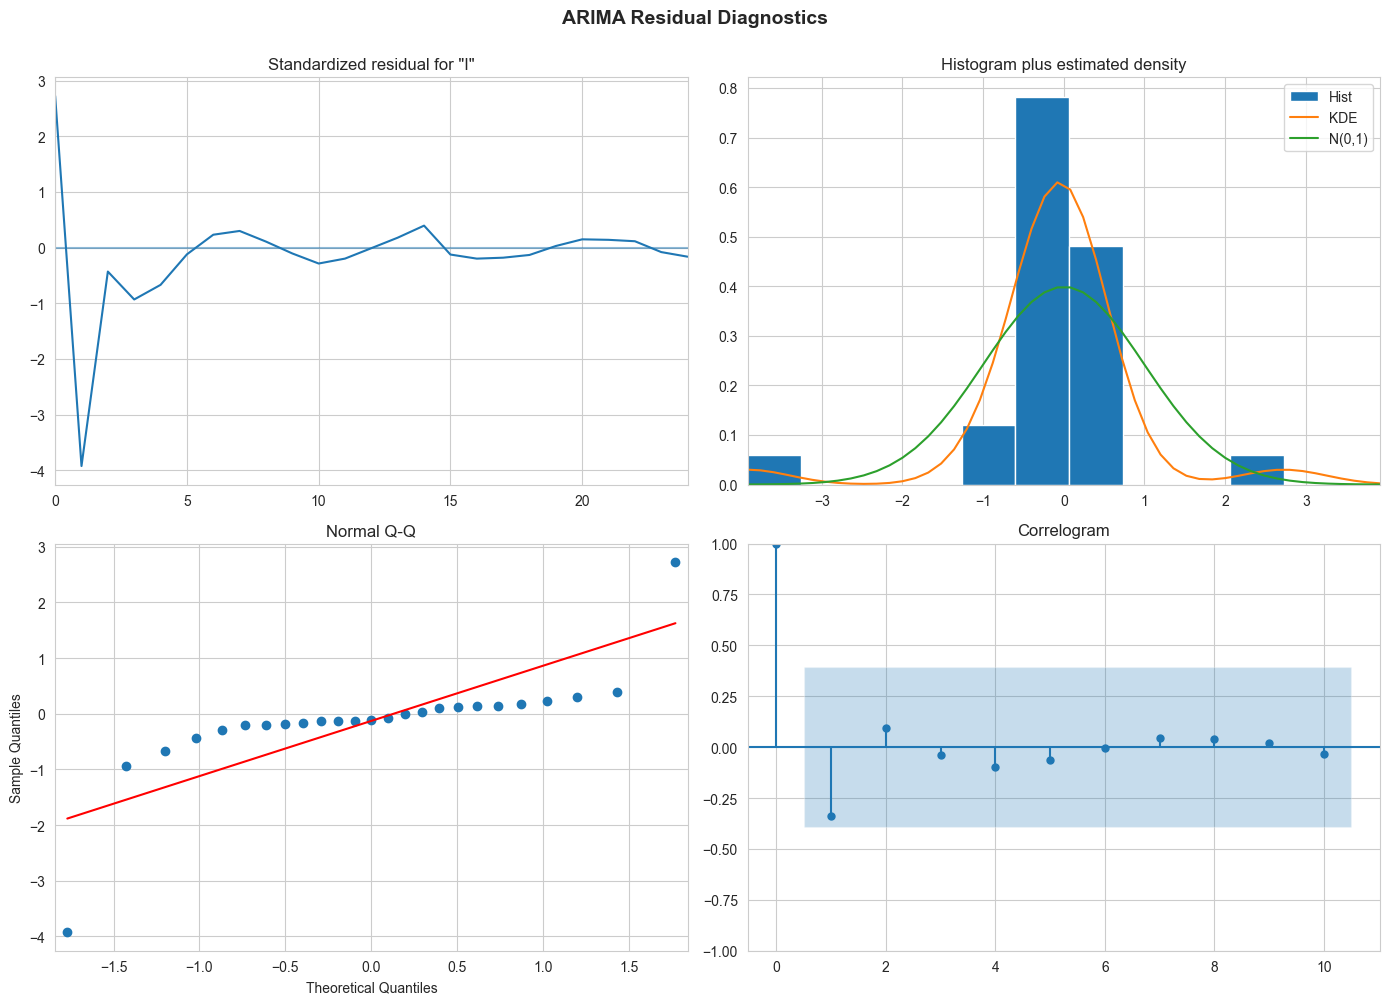


📊 How to Read the Plots:

1️⃣  Standardized Residuals (Top Left):
   ✅ Should fluctuate randomly around zero
   ❌ Patterns/trends indicate model issues

2️⃣  Histogram + KDE (Top Right):
   ✅ Should resemble normal distribution (bell curve)
   ❌ Skewness/heavy tails indicate non-normality

3️⃣  Q-Q Plot (Bottom Left):
   ✅ Points should lie on red diagonal line
   ❌ Deviations indicate non-normal residuals

4️⃣  Correlogram (Bottom Right):
   ✅ Bars should be within blue area (no autocorrelation)
   ❌ Bars outside blue area indicate remaining patterns

          LJUNG-BOX TEST (Residual Autocorrelation)
H0: Residuals are independently distributed (no autocorrelation)
H1: Residuals exhibit autocorrelation
If p-value < 0.05 → Reject H0 → Autocorrelation exists (BAD)



,lb_stat,lb_pvalue
1,6.638300,0.009981
2,10.376320,0.005582
3,15.136433,0.001704
4,18.622268,0.000932
5,21.927918,0.000540
6,21.933219,0.001245
7,21.933772,0.002608
8,21.934209,0.005039
9,21.938009,0.009078
10,21.943430,0.015395



⚠️  WARNING: Residuals show autocorrelation
   → Model may be mis-specified
   → Consider different ARIMA order

          JARQUE-BERA TEST (Normality)
H0: Residuals are normally distributed
H1: Residuals are not normally distributed

Test Statistic: 18.2390
P-value:        0.0001
Result: ❌ Residuals are NOT normally distributed
   → May indicate outliers or model mis-specification

✅ Residual diagnostics completed!


In [10]:
# ============================================================
#                 RESIDUAL DIAGNOSTICS
# ============================================================

print("="*70)
print("          RESIDUAL ANALYSIS")
print("="*70)
print("""
Good ARIMA models should have residuals that are:
1. White noise (random, no patterns)
2. Normally distributed
3. Homoscedastic (constant variance)
4. Uncorrelated (no autocorrelation)

If residuals fail these tests → model is mis-specified
""")

# Generate diagnostic plots
fig = best_model.plot_diagnostics(figsize=(14, 10))
plt.suptitle('ARIMA Residual Diagnostics', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n📊 How to Read the Plots:")
print("\n1️⃣  Standardized Residuals (Top Left):")
print("   ✅ Should fluctuate randomly around zero")
print("   ❌ Patterns/trends indicate model issues")

print("\n2️⃣  Histogram + KDE (Top Right):")
print("   ✅ Should resemble normal distribution (bell curve)")
print("   ❌ Skewness/heavy tails indicate non-normality")

print("\n3️⃣  Q-Q Plot (Bottom Left):")
print("   ✅ Points should lie on red diagonal line")
print("   ❌ Deviations indicate non-normal residuals")

print("\n4️⃣  Correlogram (Bottom Right):")
print("   ✅ Bars should be within blue area (no autocorrelation)")
print("   ❌ Bars outside blue area indicate remaining patterns")

# Ljung-Box Test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(best_model.resid, lags=10, return_df=True)

print("\n" + "="*70)
print("          LJUNG-BOX TEST (Residual Autocorrelation)")
print("="*70)
print("H0: Residuals are independently distributed (no autocorrelation)")
print("H1: Residuals exhibit autocorrelation")
print("If p-value < 0.05 → Reject H0 → Autocorrelation exists (BAD)")
print()
display(lb_test)

if (lb_test['lb_pvalue'] < 0.05).any():
    print("\n⚠️  WARNING: Residuals show autocorrelation")
    print("   → Model may be mis-specified")
    print("   → Consider different ARIMA order")
else:
    print("\n✅ Residuals pass Ljung-Box test (no autocorrelation)")

# Normality test
from scipy.stats import jarque_bera

jb_stat, jb_pval = jarque_bera(best_model.resid)
print("\n" + "="*70)
print("          JARQUE-BERA TEST (Normality)")
print("="*70)
print("H0: Residuals are normally distributed")
print("H1: Residuals are not normally distributed")
print(f"\nTest Statistic: {jb_stat:.4f}")
print(f"P-value:        {jb_pval:.4f}")

if jb_pval < 0.05:
    print("Result: ❌ Residuals are NOT normally distributed")
    print("   → May indicate outliers or model mis-specification")
else:
    print("Result: ✅ Residuals are normally distributed")

print("\n✅ Residual diagnostics completed!")

**=====Generate Predictions=====**

In [11]:
# ============================================================
#                  GENERATE PREDICTIONS
# ============================================================

print("="*70)
print("          GENERATING FORECASTS")
print("="*70)

# Get predictions for test period
start_idx = len(train_ts)
end_idx = start_idx + len(test_ts) - 1

forecast = best_model.get_prediction(start=start_idx, end=end_idx)
y_pred = forecast.predicted_mean.values

# Get confidence intervals
forecast_ci = forecast.conf_int(alpha=0.05)  # 95% CI

print(f"\nForecasting period: {test_ts['Year'].min()} - {test_ts['Year'].max()}")
print(f"Number of forecasts: {len(y_pred)}")

# Create prediction dataframe
pred_df = pd.DataFrame({
    'Year': test_ts['Year'].values,
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred,
    'Lower_CI': forecast_ci.iloc[:, 0].values,
    'Upper_CI': forecast_ci.iloc[:, 1].values
})

print("\n" + "="*70)
print("          FORECASTS WITH 95% CONFIDENCE INTERVALS")
print("="*70)
display(pred_df)

# Baseline predictions
y_pred_persist = train_ts['Inflation'].iloc[-1]  # Last training value
y_pred_persist = np.full(len(y_test), y_pred_persist)

y_pred_mean = train_ts['Inflation'].mean()
y_pred_mean = np.full(len(y_test), y_pred_mean)

print("\n✅ Predictions generated successfully!")

          GENERATING FORECASTS

Forecasting period: 2019 - 2023
Number of forecasts: 5

          FORECASTS WITH 95% CONFIDENCE INTERVALS


,Year,Actual,Predicted,Error,Lower_CI,Upper_CI
0,2019,6.556956,6.565576,-0.008620,-25.850322,38.981473
1,2020,7.033867,5.518479,1.515387,-30.934588,41.971547
2,2021,9.631789,3.860437,5.771352,-37.181029,44.901903
3,2022,8.619996,3.265662,5.354334,-46.782147,53.313471
4,2023,6.618793,3.730184,2.888609,-56.950178,64.410546



✅ Predictions generated successfully!


**=====Calculate Metrics=====**

In [12]:
# ============================================================
#                   CALCULATE METRICS
# ============================================================

# ARIMA metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape_val = mape(y_test, y_pred)
smape_val = smape(y_test, y_pred)

# Persistence baseline
mae_p = mean_absolute_error(y_test, y_pred_persist)
rmse_p = np.sqrt(mean_squared_error(y_test, y_pred_persist))
r2_p = r2_score(y_test, y_pred_persist)
mape_p = mape(y_test, y_pred_persist)
smape_p = smape(y_test, y_pred_persist)

# Mean baseline
mae_m = mean_absolute_error(y_test, y_pred_mean)
rmse_m = np.sqrt(mean_squared_error(y_test, y_pred_mean))
r2_m = r2_score(y_test, y_pred_mean)
mape_m = mape(y_test, y_pred_mean)
smape_m = smape(y_test, y_pred_mean)

print("✅ Metrics calculated!")

✅ Metrics calculated!


**=====Model Comparison=====**

In [13]:
# ============================================================
#                TEST SET PERFORMANCE
# ============================================================

comparison = pd.DataFrame({
    "Model": ["Persistence", "Mean Baseline", f"ARIMA{best_order}"],
    "MAE ↓": [mae_p, mae_m, mae],
    "RMSE ↓": [rmse_p, rmse_m, rmse],
    "R² ↑": [r2_p, r2_m, r2],
    "MAPE% ↓": [mape_p, mape_m, mape_val],
    "SMAPE% ↓": [smape_p, smape_m, smape_val]
})

# Highlight best
def highlight_best(s):
    if s.name in ['MAE ↓', 'RMSE ↓', 'MAPE% ↓', 'SMAPE% ↓']:
        is_best = s == s.min()
    else:
        is_best = s == s.max()
    return ['background-color: lightgreen; font-weight: bold' if v else '' for v in is_best]

print("="*70)
print("          TEST SET PERFORMANCE COMPARISON")
print("="*70)
display(comparison.style.apply(highlight_best, subset=comparison.columns[1:], axis=0))

# Calculate improvements
print("\n" + "="*70)
print(f"       ARIMA{best_order} IMPROVEMENT OVER BASELINES")
print("="*70)
print(f"\nMAE improvement over Persistence:   {((mae_p - mae) / mae_p * 100):+.2f}%")
print(f"MAE improvement over Mean:          {((mae_m - mae) / mae_m * 100):+.2f}%")
print(f"RMSE improvement over Persistence:  {((rmse_p - rmse) / rmse_p * 100):+.2f}%")
print(f"RMSE improvement over Mean:         {((rmse_m - rmse) / rmse_m * 100):+.2f}%")

# Summary statistics
residuals = y_test - y_pred
print("\n" + "="*70)
print("          ERROR ANALYSIS")
print("="*70)
print(f"\nResiduals: Mean={residuals.mean():.4f}, Std={residuals.std():.4f}")
print(f"Min Error: {residuals.min():.4f} (underprediction)")
print(f"Max Error: {residuals.max():.4f} (overprediction)")

          TEST SET PERFORMANCE COMPARISON


,Model,MAE ↓,RMSE ↓,R² ↑,MAPE% ↓,SMAPE% ↓
0,Persistence,2.891550,3.140143,-5.576124,36.093036,44.873793
1,Mean Baseline,9.429919,9.509091,-59.304406,127.929432,76.659500
2,"ARIMA(2, 1, 2)",3.107660,3.810982,-8.686011,37.470652,51.149736



       ARIMA(2, 1, 2) IMPROVEMENT OVER BASELINES

MAE improvement over Persistence:   -7.47%
MAE improvement over Mean:          +67.04%
RMSE improvement over Persistence:  -21.36%
RMSE improvement over Mean:         +59.92%

          ERROR ANALYSIS

Residuals: Mean=3.1042, Std=2.2108
Min Error: -0.0086 (underprediction)
Max Error: 5.7714 (overprediction)


**=====Visualizations=====**

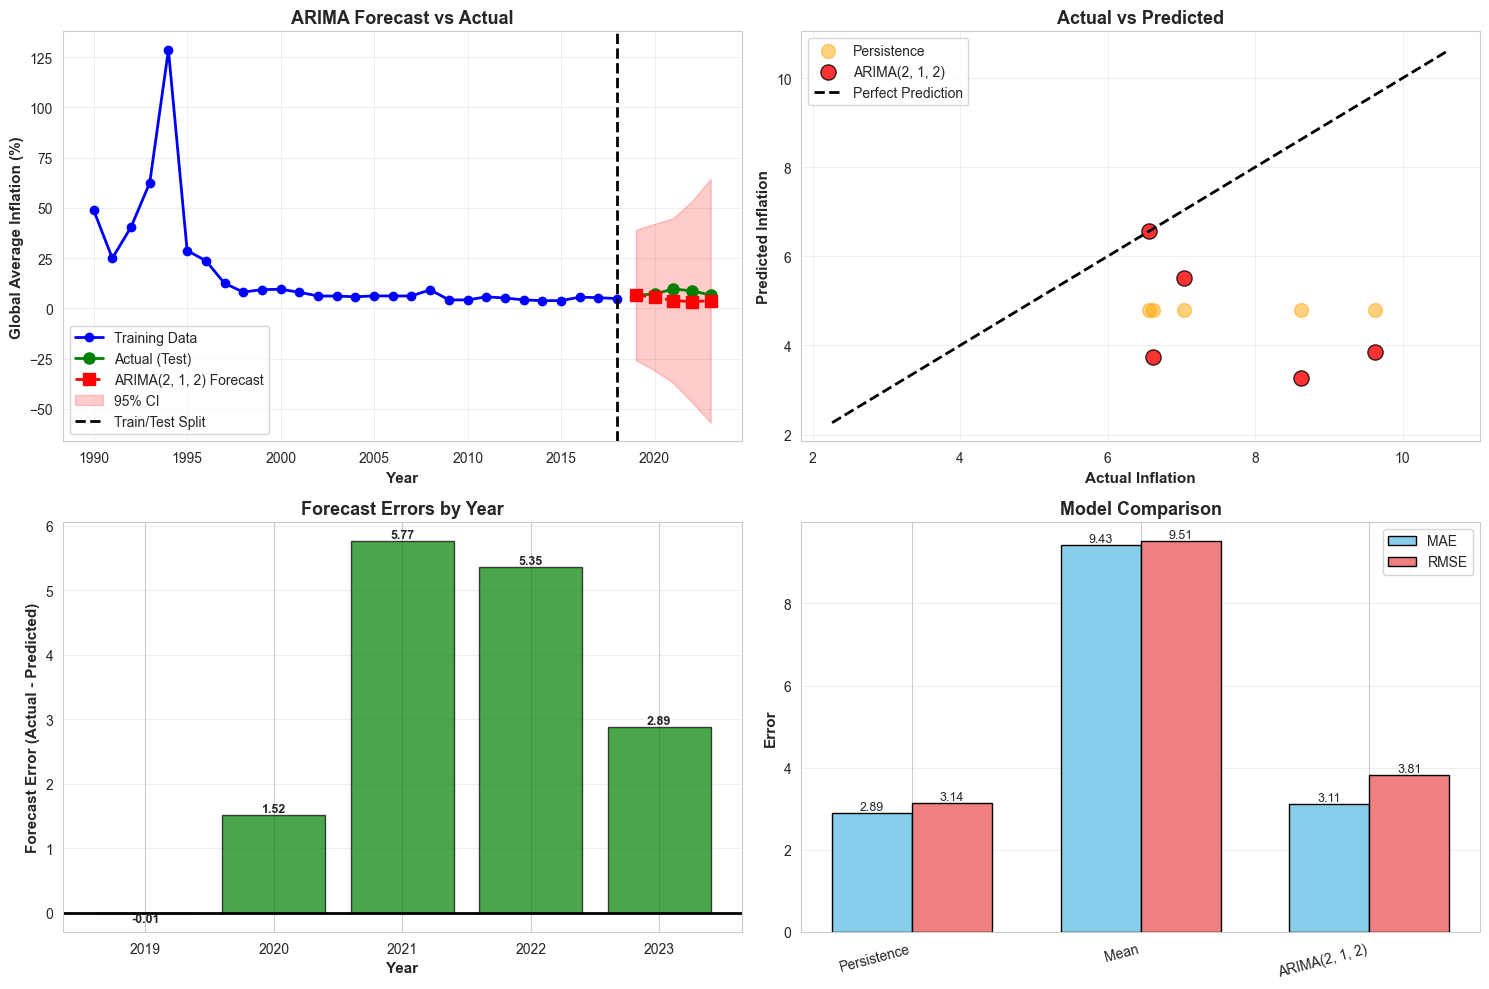

✅ Visualizations generated!


In [14]:
# ============================================================
#                    VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Time Series with Forecast
ax1 = axes[0, 0]
# Training period
ax1.plot(train_ts['Year'], train_ts['Inflation'], 'o-', 
         label='Training Data', color='blue', linewidth=2, markersize=6)
# Actual test period
ax1.plot(test_ts['Year'], y_test, 'o-', 
         label='Actual (Test)', color='green', linewidth=2, markersize=8)
# Forecast
ax1.plot(test_ts['Year'], y_pred, 's--', 
         label=f'ARIMA{best_order} Forecast', color='red', linewidth=2, markersize=8)
# Confidence interval
ax1.fill_between(test_ts['Year'], pred_df['Lower_CI'], pred_df['Upper_CI'], 
                  alpha=0.2, color='red', label='95% CI')
ax1.axvline(x=CUT_OFF_YEAR, color='black', linestyle='--', linewidth=2, label='Train/Test Split')
ax1.set_xlabel('Year', fontweight='bold', fontsize=11)
ax1.set_ylabel('Global Average Inflation (%)', fontweight='bold', fontsize=11)
ax1.set_title('ARIMA Forecast vs Actual', fontweight='bold', fontsize=13)
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Plot 2: Actual vs Predicted Scatter
ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred_persist, alpha=0.5, s=100, label='Persistence', color='orange')
ax2.scatter(y_test, y_pred, alpha=0.8, s=120, label=f'ARIMA{best_order}', color='red', edgecolors='black')
lims = [min(y_test.min(), y_pred.min())-1, max(y_test.max(), y_pred.max())+1]
ax2.plot(lims, lims, 'k--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Inflation', fontweight='bold', fontsize=11)
ax2.set_ylabel('Predicted Inflation', fontweight='bold', fontsize=11)
ax2.set_title('Actual vs Predicted', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Forecast Errors
ax3 = axes[1, 0]
colors = ['red' if e < 0 else 'green' for e in residuals]
bars = ax3.bar(test_ts['Year'], residuals, color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax3.set_xlabel('Year', fontweight='bold', fontsize=11)
ax3.set_ylabel('Forecast Error (Actual - Predicted)', fontweight='bold', fontsize=11)
ax3.set_title('Forecast Errors by Year', fontweight='bold', fontsize=13)
ax3.grid(alpha=0.3, axis='y')

# Add value labels on bars
for year, error in zip(test_ts['Year'], residuals):
    ax3.text(year, error, f'{error:.2f}', ha='center', 
             va='bottom' if error > 0 else 'top', fontsize=9, fontweight='bold')

# Plot 4: Performance Comparison
ax4 = axes[1, 1]
models = ['Persistence', 'Mean', f'ARIMA{best_order}']
mae_values = [mae_p, mae_m, mae]
rmse_values = [rmse_p, rmse_m, rmse]

x = np.arange(len(models))
width = 0.35

bars1 = ax4.bar(x - width/2, mae_values, width, label='MAE', 
                color='skyblue', edgecolor='black')
bars2 = ax4.bar(x + width/2, rmse_values, width, label='RMSE', 
                color='lightcoral', edgecolor='black')

ax4.set_ylabel('Error', fontweight='bold', fontsize=11)
ax4.set_title('Model Comparison', fontweight='bold', fontsize=13)
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=15, ha='right')
ax4.legend()
ax4.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Visualizations generated!")

**=====Save Results=====**

In [15]:
# ============================================================
#                  SAVE MODEL & RESULTS
# ============================================================

# Save ARIMA model
model_path = MODELS_DIR / f"ARIMA{best_order}.pkl"
joblib.dump(best_model, model_path)
print(f"✅ Model saved: {model_path.name}")

# Summary DataFrame
summary_df = pd.DataFrame({
    "MAE": [mae_p, mae_m, mae],
    "RMSE": [rmse_p, rmse_m, rmse],
    "R²": [r2_p, r2_m, r2],
    "MAPE%": [mape_p, mape_m, mape_val],
    "SMAPE%": [smape_p, smape_m, smape_val]
}, index=["Persistence", "Mean", f"ARIMA{best_order}"])

print("\n=== Summary ===")
display(summary_df)

# Save results dictionary
results_dict = {
    'model': best_model,
    'order': best_order,
    'metrics': {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE%': mape_val,
        'SMAPE%': smape_val
    },
    'comparison': comparison,
    'predictions': pred_df,
    'summary': summary_df,
    'aic': best_aic
}

results_path = MODELS_DIR / f"ARIMA{best_order}_Results.pkl"
joblib.dump(results_dict, results_path)
print(f"✅ Results saved: {results_path.name}")

# ============================================================
#                  FINAL PERFORMANCE SUMMARY
# ============================================================
print("\n" + "="*70)
print("          ARIMA MODEL - FINAL PERFORMANCE")
print("="*70)
print(f"\n🏆 Best Model: ARIMA{best_order}")
print(f"\n📊 Test Set Performance:")
print(f"   MAE:    {mae:.4f}")
print(f"   RMSE:   {rmse:.4f}")
print(f"   R²:     {r2:.4f}")
print(f"   MAPE:   {mape_val:.2f}%")
print(f"   SMAPE:  {smape_val:.2f}%")

print(f"\n🔍 Model Characteristics:")
print(f"   Training Period: {train_ts['Year'].min()}-{train_ts['Year'].max()} ({len(train_ts)} observations)")
print(f"   Test Period:     {test_ts['Year'].min()}-{test_ts['Year'].max()} ({len(test_ts)} observations)")
print(f"   AIC Score:       {best_aic:.2f}")

print(f"\n✅ ARIMA analysis completed successfully!")
print("="*70)

✅ Model saved: ARIMA(2, 1, 2).pkl

=== Summary ===


,MAE,RMSE,R²,MAPE%,SMAPE%
Persistence,2.891550,3.140143,-5.576124,36.093036,44.873793
Mean,9.429919,9.509091,-59.304406,127.929432,76.659500
"ARIMA(2, 1, 2)",3.107660,3.810982,-8.686011,37.470652,51.149736


✅ Results saved: ARIMA(2, 1, 2)_Results.pkl

          ARIMA MODEL - FINAL PERFORMANCE

🏆 Best Model: ARIMA(2, 1, 2)

📊 Test Set Performance:
   MAE:    3.1077
   RMSE:   3.8110
   R²:     -8.6860
   MAPE:   37.47%
   SMAPE:  51.15%

🔍 Model Characteristics:
   Training Period: 1990-2018 (29 observations)
   Test Period:     2019-2023 (5 observations)
   AIC Score:       224.01

✅ ARIMA analysis completed successfully!
